In [1]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x1554e5910>)

In [3]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in /Users/aman/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


/Users/aman/Developer/MIDAS/env/lib/python3.9/site-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /Users/aman/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /Users/aman/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.p

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/aman/.cache/torch/hub/intel-isl_MiDaS_master


In [6]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [7]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

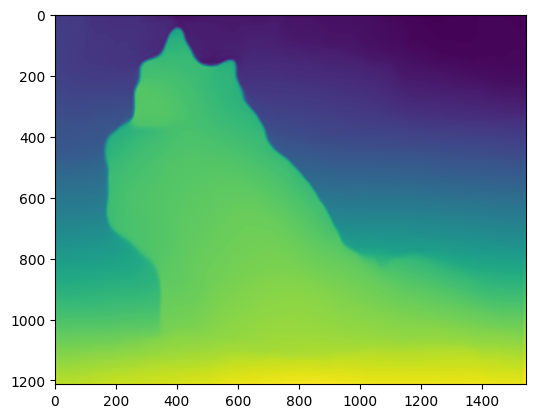

In [8]:
plt.imshow(output)
# plt.show()

In [9]:
import os
def vid_to_frames():
    location = 'des.mp4'
    cam = cv2.VideoCapture(location) 
    try:
        if not os.path.exists('tmp'):
            os.makedirs('tmp')
    except OSError:
        print ('Error: Creating directory of data')

    currentframe = 0
    while(True):
        ret,frame = cam.read()
        if ret:
            name = 'tmp/'+ str(currentframe) + '.jpg'
            cv2.imwrite(name, frame)
            currentframe += 1
        else:
            break
    cam.release()
    cv2.destroyAllWindows()

In [10]:
def frame_segmentation():
    directory = 'tmp'
    for filename in sorted(os.listdir(directory)):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            img = cv2.imread(f)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            input_batch = transform(img).to(device)
            with torch.no_grad():
                prediction = midas(input_batch)
            prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
            ).squeeze()

        output = prediction.cpu().numpy()
        plt.imshow(output)
        plt.axis('off')
        plt.savefig(f)
        plt.close()

In [11]:
def frame_to_vid():

    img_array = []
    dir_len=len([name for name in os.listdir('tmp') if os.path.isfile(os.path.join('tmp', name))])
    for i in range(0,dir_len):
        img = cv2.imread('tmp/'+str(i)+'.jpg')
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
    out = cv2.VideoWriter('output.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 30, size )
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [12]:
print('<<<Undergoing Video Fragmentation>>> ')
vid_to_frames()
print('<<<Undergoing Frame Segmentation>>>')
frame_segmentation()
print('<<<Undergoing Frame Concatenation>>>')
frame_to_vid()

<<<Undergoing Video Fragmentation>>> 
<<<Undergoing Frame Segmentation>>>
<<<Undergoing Frame Concatenation>>>


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
